Loading and Plotting surface EMG Data
=====================================

Here we show how to load and visualize EMG data collected at the wrist as described in the paper ["A generic noninvasive neuromotor interface for human-computer interaction"](https://www.biorxiv.org/content/10.1101/2024.02.23.581779v1.full.pdf). We will show examples from each of the three tasks described in the paper: `discrete_gestures`, `handwriting`, and `wrist_pose`.

# Setup

First download the data, as described in the `README`. If necessary, set the `root_data_folder` below to the location of the files.

In [1]:
%load_ext autoreload
%autoreload 2


from neuromotor_data_loading.plot import plot_emg, plot_wrist
from neuromotor_data_loading.load import load_data
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import glob
import os


root_data_folder = "~/emg_data/"


def get_task_files(root_data_folder: str, task: str):
    """Get all hdf5 files for a given task (discrete_gestures, handwriting, or wrist_pose)."""
    task_folder = os.path.join(os.path.expanduser(root_data_folder), task)
    return glob.glob(os.path.join(task_folder, '*.hdf5'))

# Loading data

Next we'll select one of the `discrete_gesture` files.

In [2]:
file = get_task_files(root_data_folder, "discrete_gestures")[0]
print("Selected file:", os.path.basename(file))

Selected file: 2022-02-25-1645823054-combined-controls-dca-right@3-a07d5b4f-be7f-412a-afc8-b27edeb79248.hdf5


We'll load the file using the `load_data` utility function.

In [3]:
data = load_data(file)
data

The file contains EMG, timestamps, a task identifier, `prompts` dataframe with the timing of all the gestures, and a `stages` dataframe with the timing of the different experimental stages.

In [4]:
print("task:            ", data.task)
print("emg shape:       ", data.emg.shape)
print("timestamp shape: ", data.time.shape)
print("stages:")
display(data.stages.head())
print("prompts:")
display(data.prompts)

task:             discrete_gestures
emg shape:        (2989048, 16)
timestamp shape:  (2989048,)
stages:


,start,end,name
0,1.645823e+09,1.645823e+09,standing_arm_rest
1,1.645823e+09,1.645823e+09,pinch_practice
2,1.645823e+09,1.645823e+09,pnr_static_hand_in_lap_with_taps_audrey
3,1.645823e+09,1.645823e+09,thumb_swipes_practice_audrey
4,1.645823e+09,1.645823e+09,thumb_swipes_static_arm_in_lap_audrey


prompts:


,name,time
0,middle_press,1.645823e+09
1,middle_release,1.645823e+09
2,middle_press,1.645823e+09
3,middle_release,1.645823e+09
4,index_press,1.645823e+09
...,...,...
1165,thumb_down,1.645824e+09
1166,thumb_up,1.645824e+09
1167,thumb_out,1.645824e+09
1168,thumb_out,1.645824e+09


Data are similarly structured for the `handwriting` datasets. However, the dataframe now encodes the start and end times of each text prompt.

In [5]:
file = get_task_files(root_data_folder, "handwriting")[0]
data = load_data(file)

print("task:            ", data.task)
print("emg shape:       ", data.emg.shape)
print("timestamp shape: ", data.time.shape)
print("stages:")
display(data.stages.head())
print("prompts:")
display(data.prompts)

task:             handwriting
emg shape:        (1532824, 16)
timestamp shape:  (1532824,)
stages:


,start,end,name,posture
0,1.666020e+09,1.666020e+09,characters_with_digits,standing-on-leg
1,1.666020e+09,1.666020e+09,characters_with_digits,standing-on-leg
2,1.666020e+09,1.666020e+09,characters_with_digits,standing-on-leg
3,1.666020e+09,1.666020e+09,characters_with_digits,standing-on-leg
4,1.666020e+09,1.666020e+09,characters_with_digits,standing-on-leg


prompts:


,prompt,start,end
0,k,1.666020e+09,1.666020e+09
1,a,1.666020e+09,1.666020e+09
2,0,1.666020e+09,1.666020e+09
3,u,1.666020e+09,1.666020e+09
4,',1.666020e+09,1.666020e+09
...,...,...,...
89,water is a molecule🤏,1.666020e+09,1.666020e+09
90,that consists of one🤏,1.666020e+09,1.666021e+09
91,lesothorf.←←← national football team🤏,1.666021e+09,1.666021e+09
92,opinion→ sections→ usually→ also🤏,1.666021e+09,1.666021e+09


The `wrist_pose` datasets do not have a `prompts` dataframe. Instead, they have an additional stream of `wrist_angles` data.

In [6]:
file = get_task_files(root_data_folder, "wrist_pose")[0]
data = load_data(file)

print("task:               ", data.task)
print("emg shape:          ", data.emg.shape)
print("wrist_angles shape: ", data.wrist_angles.shape)
print("timestamp shape:    ", data.time.shape)
print("stages:")
display(data.stages.head())

task:                wrist_pose
emg shape:           (3482132, 16)
wrist_angles shape:  (3482132, 3)
timestamp shape:     (3482132,)
stages:


,start,end,name
0,1.714587e+09,1.714587e+09,open_loop_task
1,1.714587e+09,1.714587e+09,cursor_to_target_task_horizontal_low_gain_bloc...
2,1.714587e+09,1.714587e+09,cursor_to_target_task_horizontal_low_gain_bloc...
3,1.714587e+09,1.714587e+09,cursor_to_target_task_horizontal_low_gain_bloc...
4,1.714587e+09,1.714587e+09,cursor_to_target_task_horizontal_low_gain_bloc...


# Plotting data

## Discrete Gestures

Here we plot EMG snippets for a single `discrete_gesture` dataset in 1 second windows centered on different gesture types.

Notice the use of `gesture_data.partition(start_time, end_time)` to extract windows of EMG around events of interest.

In [7]:
gesture_file = get_task_files(root_data_folder, "discrete_gestures")[0]
gesture_data = load_data(gesture_file)

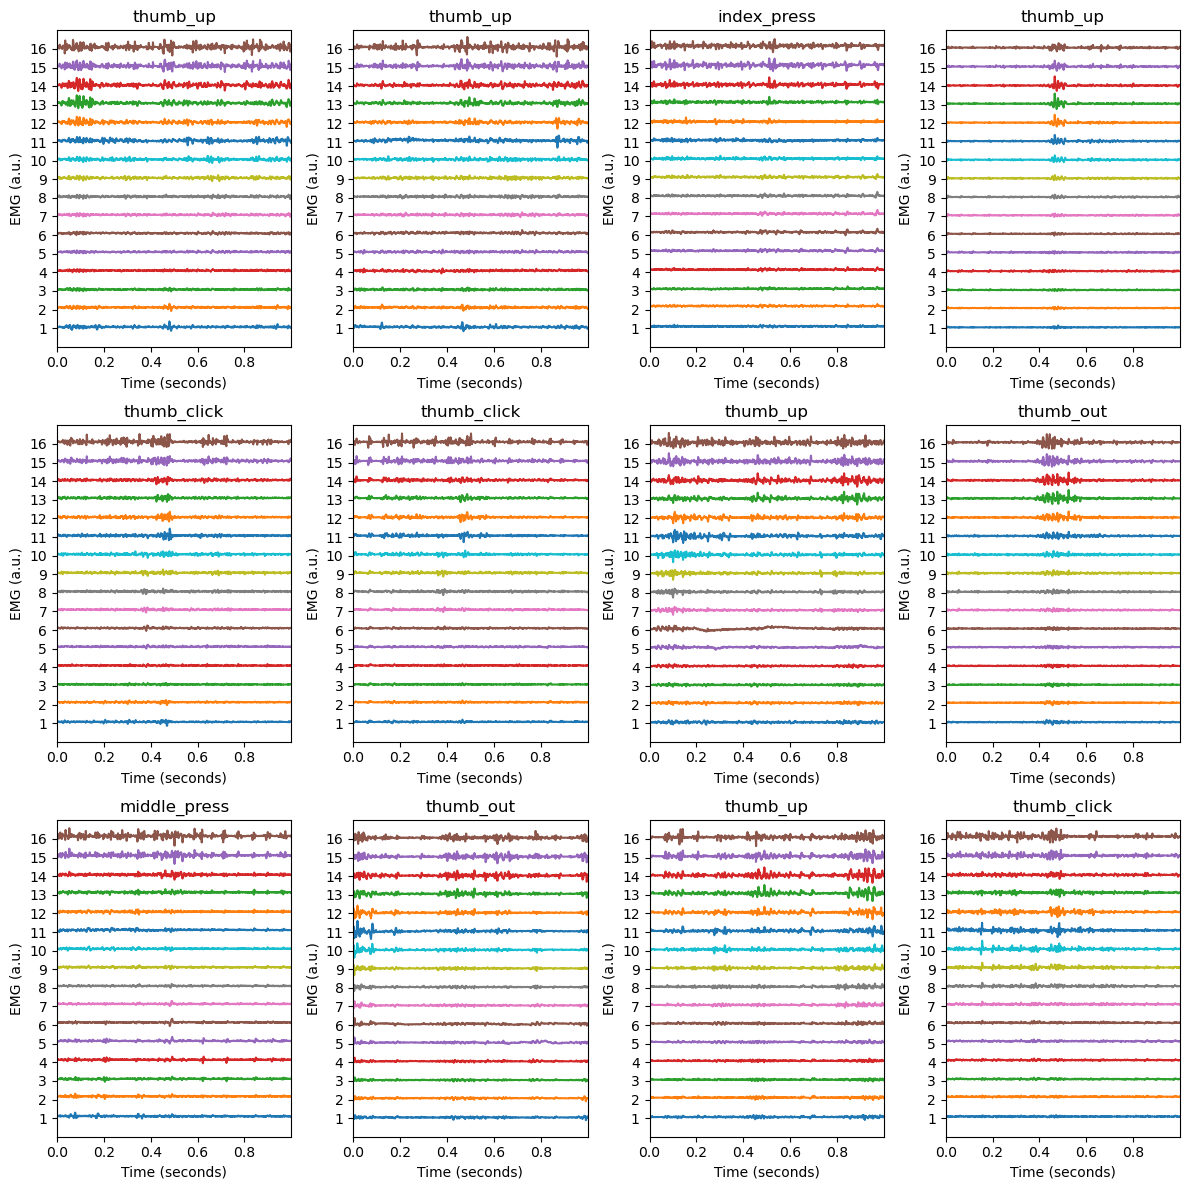

In [8]:
window = [-.5, .5]
nrows = 3
ncols = 4

fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 3, nrows * 4))

# Sample random gestures
gestures = gesture_data.prompts.sample(nrows * ncols, random_state=0, replace=False)

for ax, (_, gesture) in zip(axs.flatten(), gestures.iterrows()):
    timeseries = gesture_data.partition(gesture.time + window[0], gesture.time + window[1])
    plot_emg(timeseries["time"], timeseries["emg"], ax=ax)
    gesture_name = gesture.loc["name"]
    ax.set(title=f"{gesture_name}")

plt.tight_layout()

## Handwriting

Now we plot snippets of `handwriting` EMG corresponding to individual text prompts.

In [9]:
handwriting_file = get_task_files(root_data_folder, "handwriting")[0]
handwriting_data = load_data(handwriting_file)

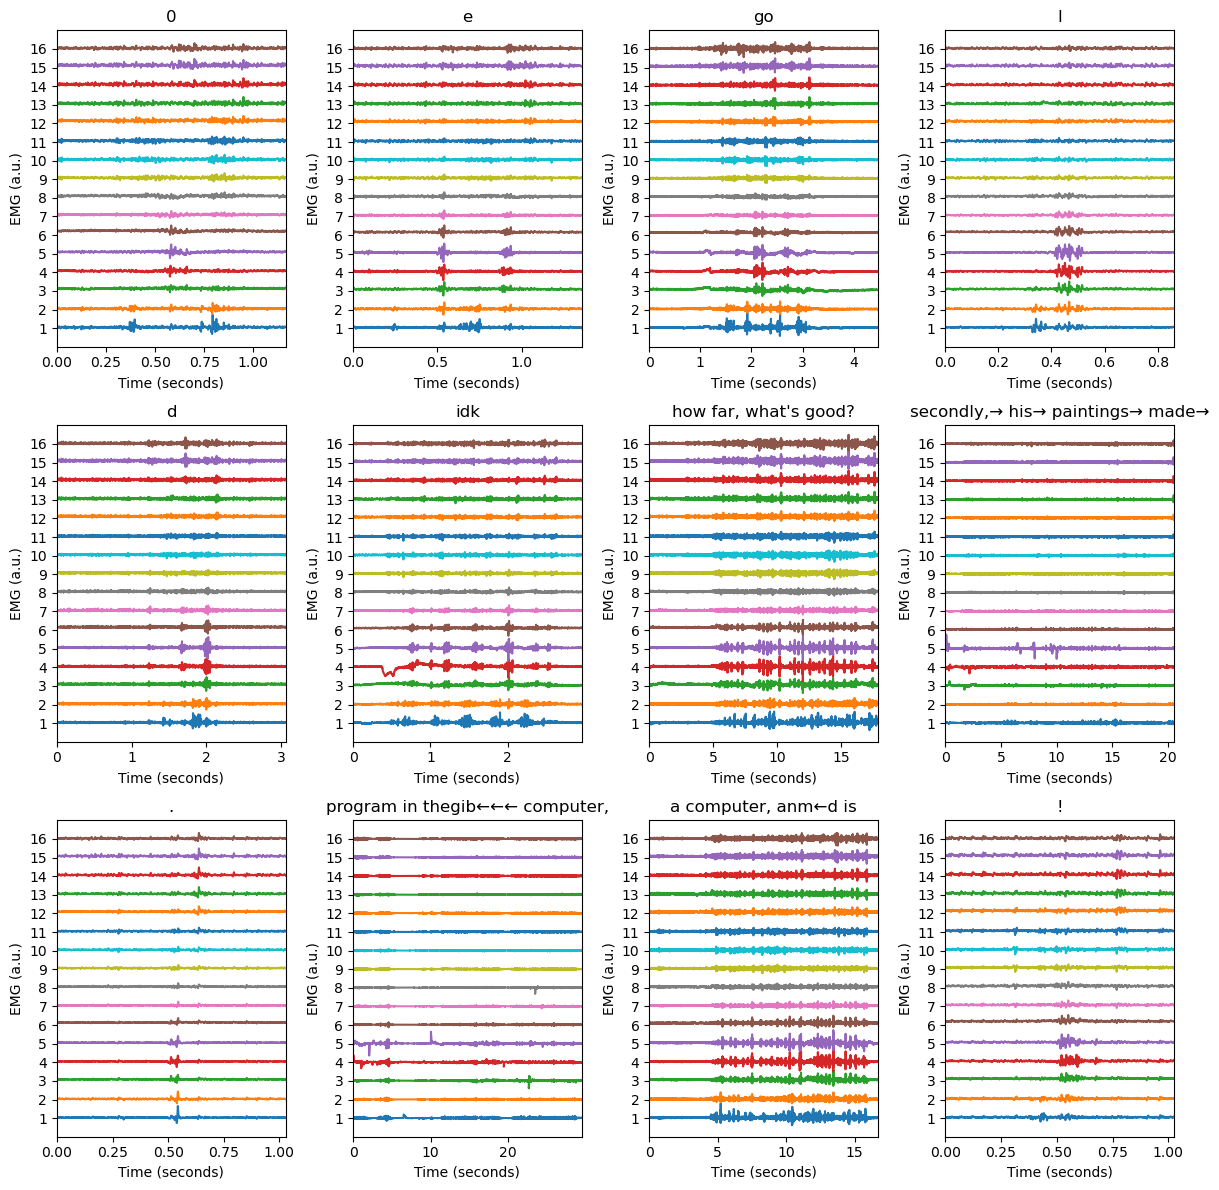

In [10]:
nrows = 3
ncols = 4

fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 3, nrows * 4))

# Sample random prompts
prompts = handwriting_data.prompts.sample(nrows * ncols, random_state=0, replace=False)

for ax, (_, prompt) in zip(axs.flatten(), prompts.iterrows()):
    timeseries = handwriting_data.partition(prompt.start, prompt.end)
    plot_emg(timeseries["time"], timeseries["emg"], ax=ax)
    ax.set(title=f"{prompt.prompt}")

plt.tight_layout()

## Wrist pose

Finally, we'll plot EMG and wrist angles side-by-side for a few example stages from a `wrist_pose` dataset.

In [11]:
wrist_file = get_task_files(root_data_folder, "wrist_pose")[0]
wrist_data = load_data(wrist_file)

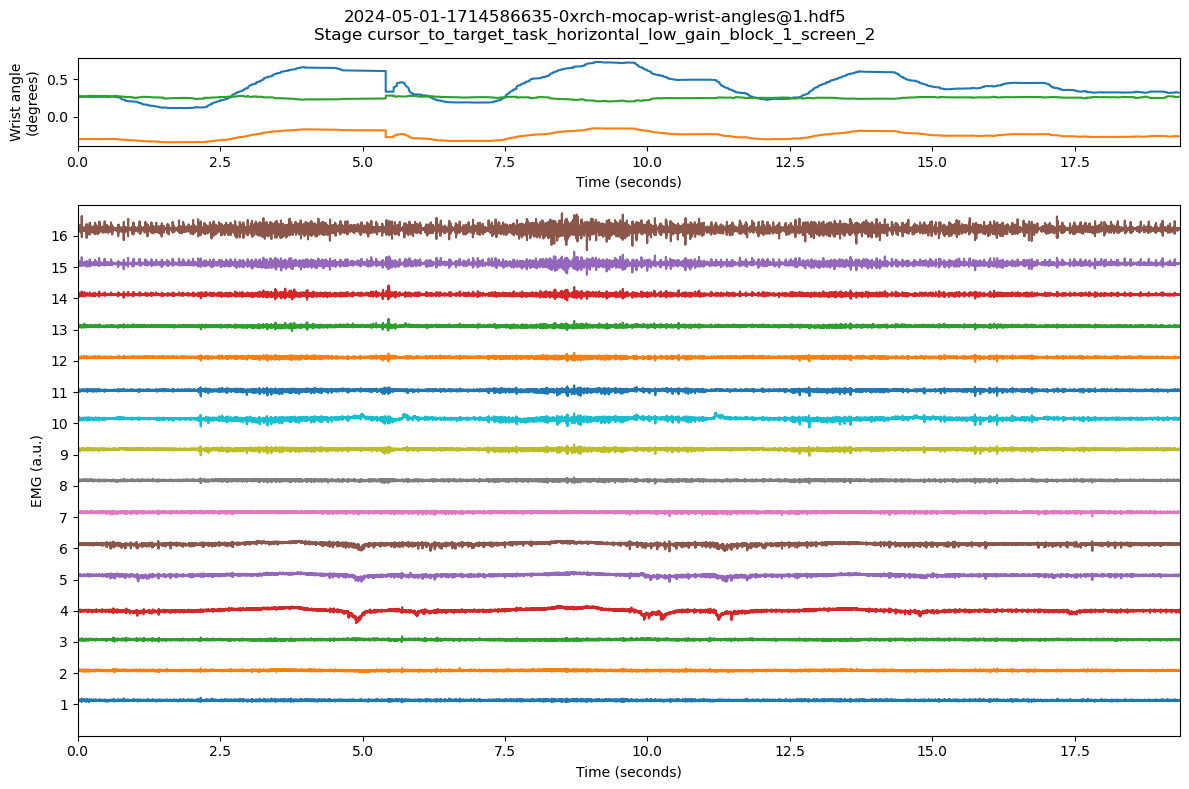

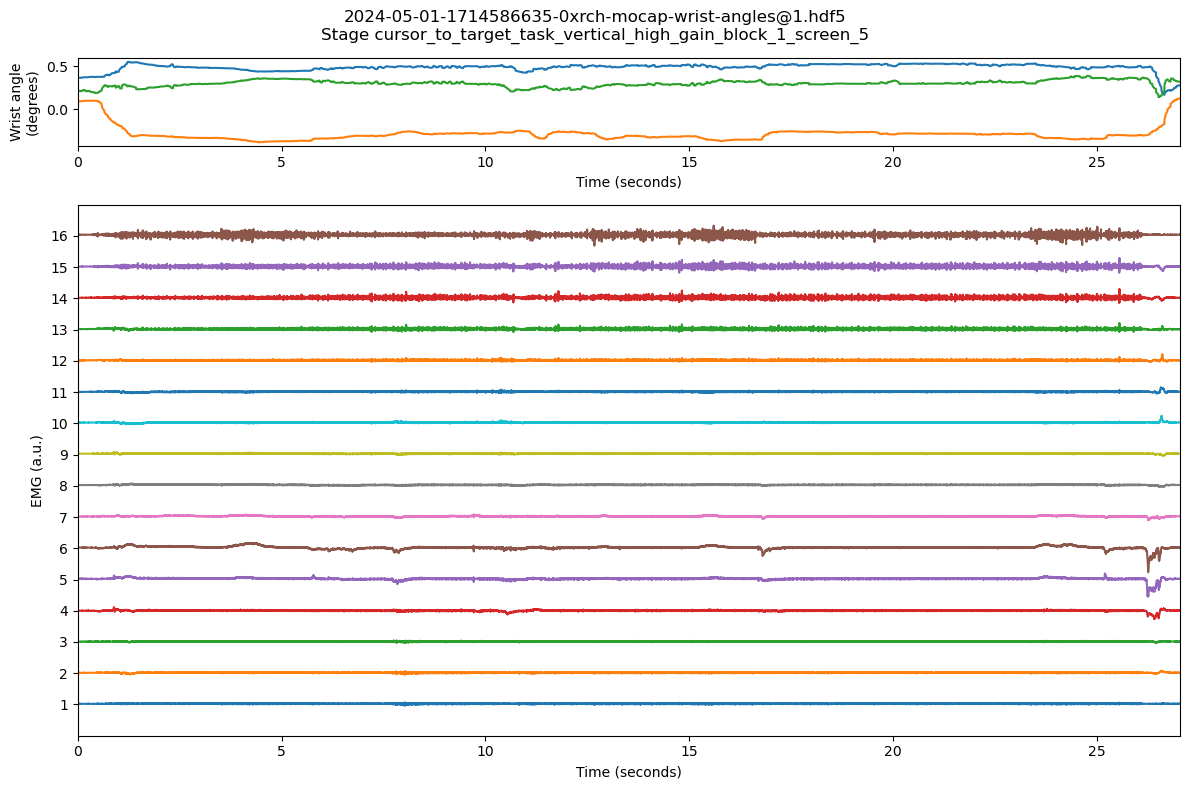

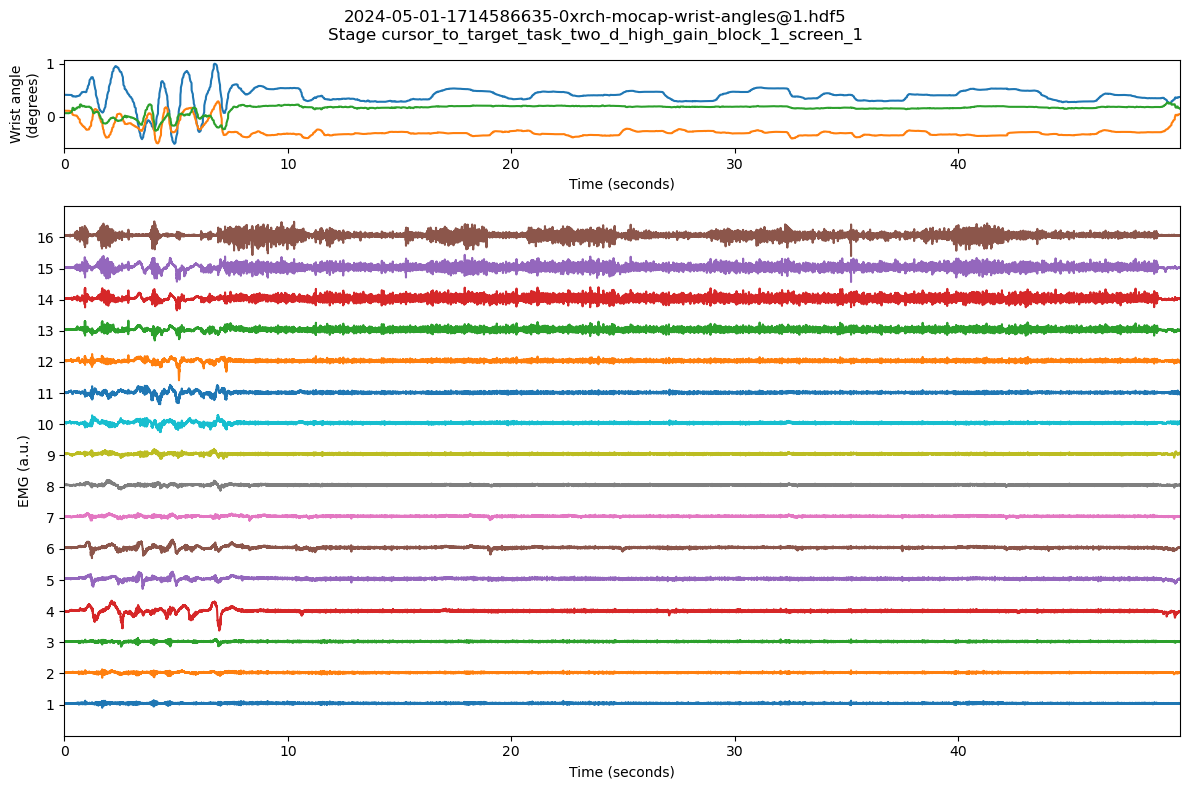

In [12]:
num_stages = 3

# Sample random stages
stages = wrist_data.stages.sample(num_stages, random_state=0, replace=False)

for _, stage in stages.iterrows():
    fig, axs = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={"height_ratios": [1, 6]})
    timeseries = wrist_data.partition(stage.start, stage.end)
    
    plot_wrist(timeseries["time"], timeseries["wrist_angles"], ax=axs[0])
    plot_emg(timeseries["time"], timeseries["emg"], ax=axs[1])

    fig.suptitle(f"{os.path.basename(wrist_file)}\nStage {stage['name']}")
    plt.tight_layout()